In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


In [33]:
import os
from pathlib import Path
import itertools
from io import BytesIO
import time
import json
import zlib

import numpy as np
import scipy
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier

from nuscenes.nuscenes import NuScenes

import lmdb

from tqdm import tqdm

import utils
from utils import bytes_to_array
import nusc_utils

from bev_gt import generate_gt_bev_map
from bev2 import BEV, generate_bev_seg_map

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini/').resolve()
nuscenes = NuScenes(version='v1.0-mini', dataroot=str(dataroot), verbose=False)
scene_idx = 0
sample_idx = 30

In [5]:
scene = nuscenes.scene[scene_idx]
sample = list(nusc_utils.sample_gen(nuscenes, scene))[sample_idx]

In [6]:
bev = BEV(nuscenes, sample)
bev.load_cam_data(cam='CAM_FRONT')

In [7]:
image_points_fov, cam_points_fov, idx = bev.project_lidar_to_image_plane()
depth_map = bev.interpolate_depth(xy=image_points_fov, z=cam_points_fov[:, 2], method='linear')

In [8]:
lidar_seg_fov = bev.lidar_seg[idx]

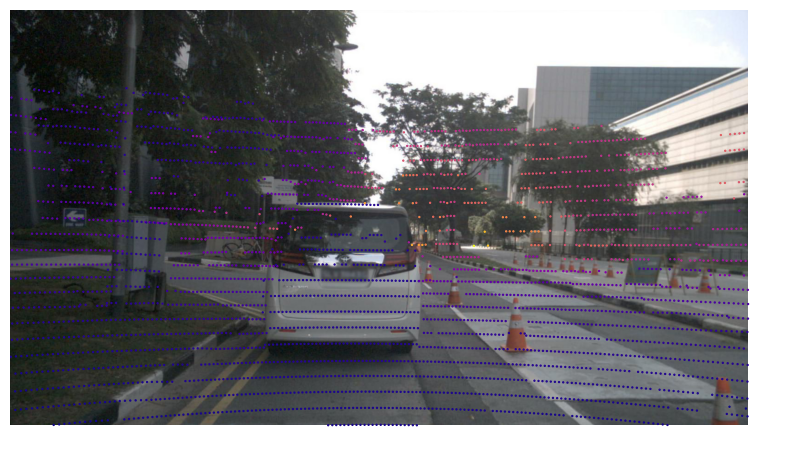

In [121]:
plt.figure(figsize=(10,10))
plt.imshow(bev.img)
plt.axis('off')
plt.scatter(image_points_fov[:, 0], image_points_fov[:, 1], c=cam_points_fov[:,2], s=0.5,
                   cmap='plasma')

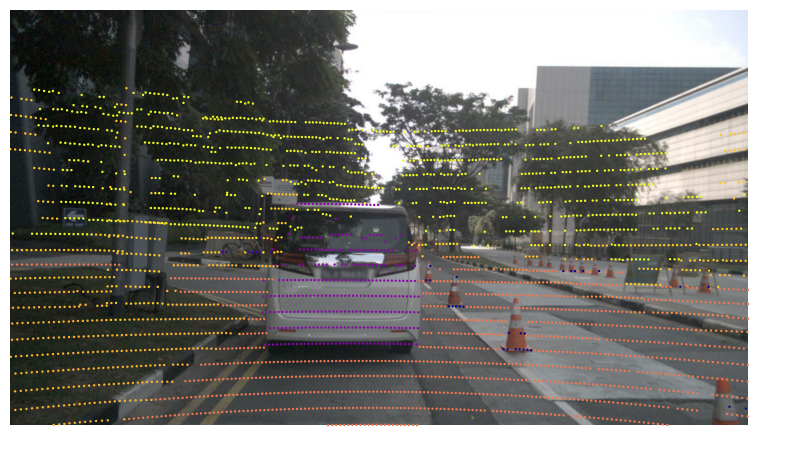

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(bev.img)
plt.axis('off')
plt.scatter(image_points_fov[:, 0], image_points_fov[:, 1], c=lidar_seg_fov, s=0.5,
                   cmap='plasma')

In [43]:
bev.lidarseg_new_name2idx_mapping['car'], bev.lidarseg_new_name2idx_mapping['driveable_surface']

(17, 24)

In [16]:
bev_seg_map = np.zeros((14, 200, 200))
for i, cls_label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES):
    cls_idx = bev.lidarseg_new_name2idx_mapping[cls_label]
    idx = np.where(lidar_seg_fov == cls_idx)[0]
    u = image_points_fov[idx][:,0]
    z = cam_points_fov[idx, 2]
    bev_seg_map[i, :, :] = bev.project_to_bev(u, z)

In [17]:
bev_gt_map = generate_gt_bev_map(nuscenes, scene, sample)
bev_gt_map_cmp = utils.make_composite(bev_gt_map)
bev_seg_map_cmp = utils.make_composite(bev_seg_map)
color_map = {i + 1: c for i, c in bev.nusc_idx_to_color.items()}
color_map[0] = [255, 255, 255]
color_map[2] = [255, 255, 255]  # do not plot "other_flat"
color_map[4] = [255, 255, 255]  # do not plot "terrain"
color_map[15] = [255, 255, 255]  # do not plot "lidar mask"

bev_gt_map_cmp_color = utils.color_components(bev_gt_map_cmp, color_map=color_map)
bev_seg_map_cmp_color = utils.color_components(bev_seg_map_cmp, color_map=color_map)

(-0.5, 199.5, 199.5, -0.5)

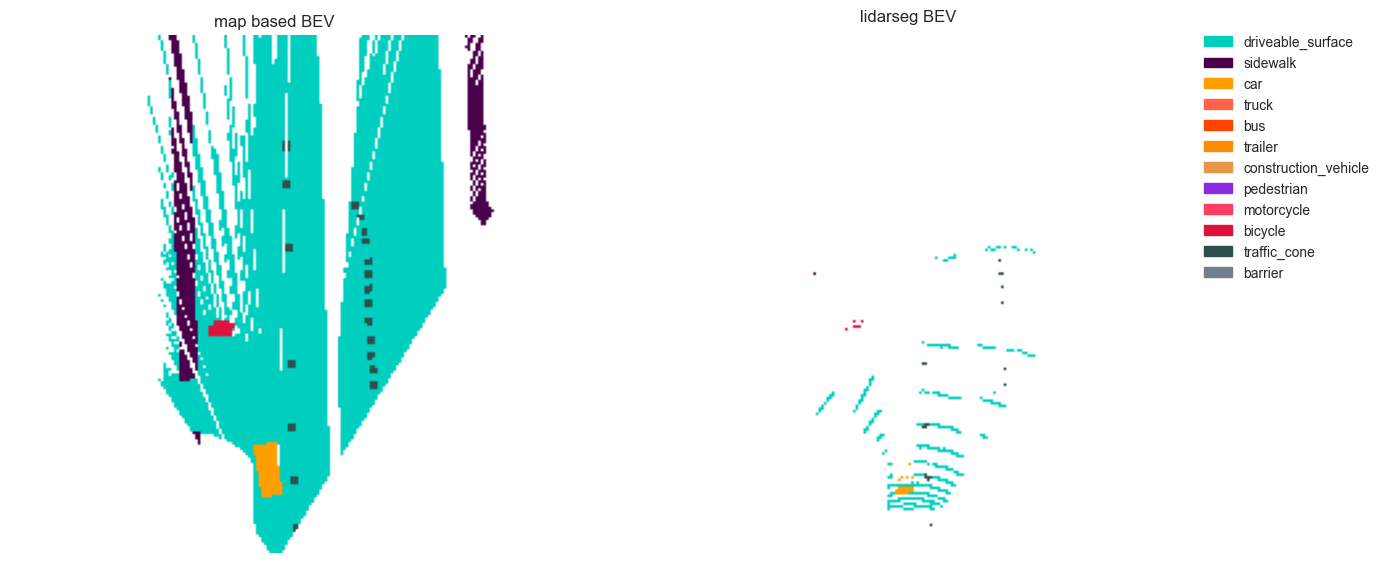

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
ax = axs[0]
ax.imshow(cv2.flip(bev_gt_map_cmp_color, 0))
ax.set_title('map based BEV')
ax.axis('off')

ax = axs[1]
ax.imshow(bev_seg_map_cmp_color)
ax.set_title('lidarseg BEV')

legend_colors = [np.append(np.array(bev.nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(bev.nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('off')

In [19]:
fig.savefig('sparse_lidar_raw_bev.png', dpi=300, bbox_inches='tight')

In [24]:
raw_db_path = dataroot / Path('lmdb/samples/SPARSE_RAW_BEV_CAM_FRONT')
raw_db = lmdb.open(path=str(raw_db_path), readonly=True)

In [22]:
def db_value_to_array(value):
    value_unzipped = zlib.decompress(value)
    return bytes_to_array(value_unzipped)

In [31]:
cam_token = sample['data']['CAM_FRONT']
cam_token_bytes = str.encode(cam_token, 'utf-8')
cam_token_bytes

b'5979f20786b745c5b05c21d8badc2ed8'

In [34]:
with raw_db.begin() as txn:
    value = txn.get(cam_token_bytes)
    bev_raw = db_value_to_array(value)
bev_raw.shape

(14, 200, 200)

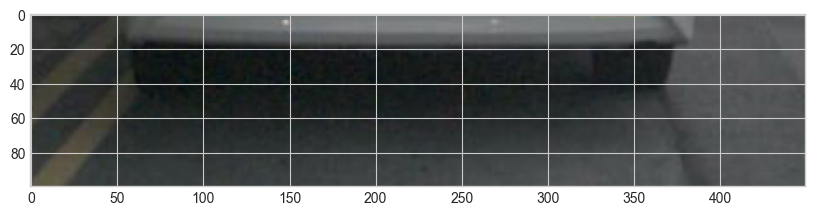

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(bev.img[700:800, 500:950])

In [114]:
car_mask = (image_points_fov[:,0] >= 500) &\
           (image_points_fov[:,0] <= 950) &\
           (image_points_fov[:,1] >= 700) &\
           (image_points_fov[:,1] <= 800)
np.sum(car_mask)

172

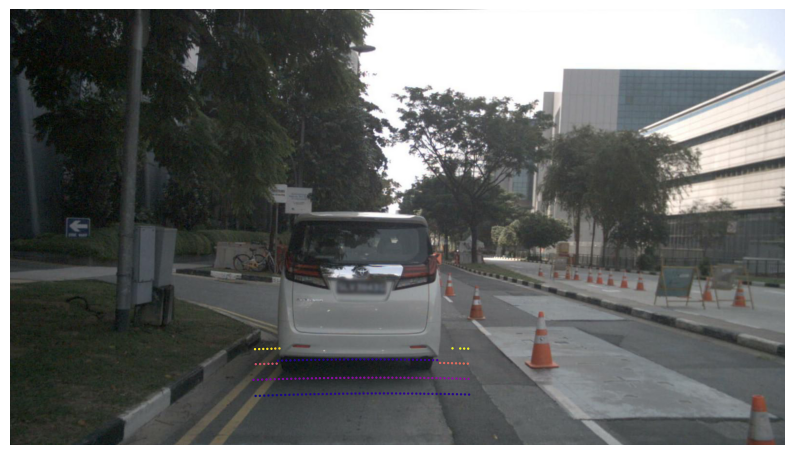

In [116]:
plt.figure(figsize=(10,10))
plt.imshow(bev.img)
plt.axis('off')
plt.scatter(image_points_fov[car_mask][:, 0], image_points_fov[car_mask][:, 1], c=cam_points_fov[car_mask][:,2], s=0.5,
                   cmap='plasma')

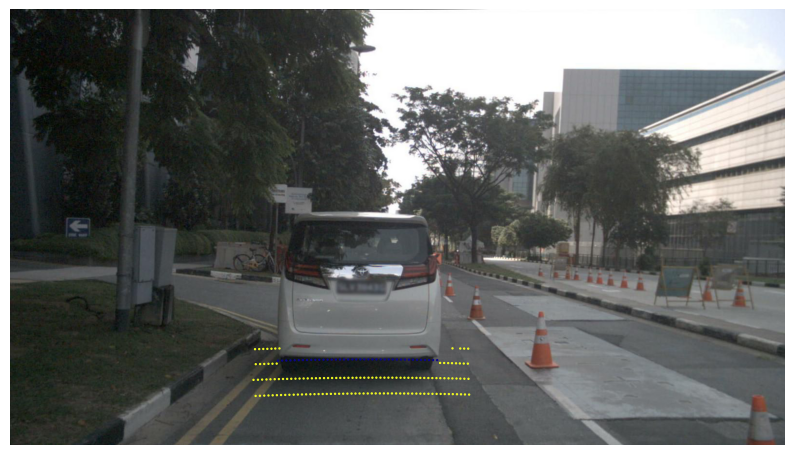

In [117]:
plt.figure(figsize=(10,10))
plt.imshow(bev.img)
plt.axis('off')
plt.scatter(image_points_fov[car_mask][:, 0], image_points_fov[car_mask][:, 1], c=lidar_seg_fov[car_mask], s=0.5,
                   cmap='plasma')

In [118]:
car_idx=17
drv_idx=24

In [119]:
idx = np.where((lidar_seg_fov == car_idx) & car_mask)[0]
print(idx.shape, 'car')
u = image_points_fov[idx][:,0]
z = cam_points_fov[idx, 2]
car_proj = bev.project_to_bev(u, z)

idx = np.where((lidar_seg_fov == drv_idx) & car_mask)[0]
print(idx.shape, 'drv')
u = image_points_fov[idx][:,0]
z = cam_points_fov[idx, 2]
drv_proj = bev.project_to_bev(u, z)

(40,) car
(132,) drv


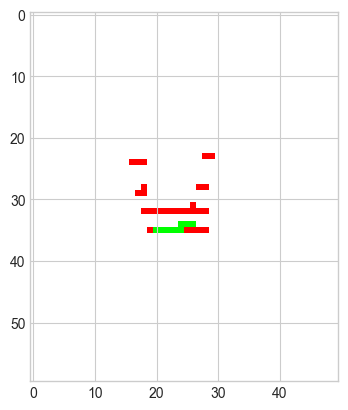

In [120]:
seg_img_2 = np.zeros((200,200,3), dtype=np.uint8)
seg_img_2[:,:]= (255,255,255)
xx, yy = np.where(drv_proj)
seg_img_2[xx, yy] = (255, 0, 0)

xx, yy = np.where(car_proj)
seg_img_2[xx, yy] = (0, 255, 0)

plt.imshow(seg_img_2[140:, 75:125, ])

In [128]:
tokens=[]
for sc in nuscenes.scene:
    for s in list(nusc_utils.sample_gen(nuscenes, scene)):
        tokens.append(s['data']['CAM_FRONT'])
with open('v1.0-mini-CAM_FRONT_token.json', 'w') as f:
    json.dump(tokens, f)